In [14]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import gc

In [15]:
from prj.config import DATA_DIR


BASE_PATH = DATA_DIR  / 'train'
partition = 5
train_ds = pl.concat([
    pl.scan_parquet(BASE_PATH / f'partition_id={i}' / 'part-0.parquet')
    for i in range(partition, partition + 1)
]).collect()

In [29]:
train_ds.fill_nan(None).null_count().transpose(include_header=True).with_columns(
    pl.col('column_0').truediv(train_ds.shape[0]).mul(100).alias('null_ratio%')
).drop('column_0').sort('null_ratio%', descending=True)

shape: (92, 2)
┌─────────────┬─────────────┐
│ column      ┆ null_ratio% │
│ ---         ┆ ---         │
│ str         ┆ f64         │
╞═════════════╪═════════════╡
│ feature_39  ┆ 7.024793    │
│ feature_42  ┆ 7.024793    │
│ feature_50  ┆ 7.024793    │
│ feature_53  ┆ 7.024793    │
│ feature_15  ┆ 2.479376    │
│ …           ┆ …           │
│ responder_4 ┆ 0.0         │
│ responder_5 ┆ 0.0         │
│ responder_6 ┆ 0.0         │
│ responder_7 ┆ 0.0         │
│ responder_8 ┆ 0.0         │
└─────────────┴─────────────┘

In [6]:
parts = pl.concat([
    pl.scan_parquet(BASE_PATH / f'partition_id={i}' / 'part-0.parquet') \
        .select(['date_id', 'time_id', 'symbol_id']) \
        .with_columns(pl.lit(i).cast(pl.Int8).alias('part')).collect()
    for i in range(10)
])
parts.head()

shape: (5, 4)
┌─────────┬─────────┬───────────┬──────┐
│ date_id ┆ time_id ┆ symbol_id ┆ part │
│ ---     ┆ ---     ┆ ---       ┆ ---  │
│ i16     ┆ i16     ┆ i8        ┆ i8   │
╞═════════╪═════════╪═══════════╪══════╡
│ 0       ┆ 0       ┆ 1         ┆ 0    │
│ 0       ┆ 0       ┆ 7         ┆ 0    │
│ 0       ┆ 0       ┆ 9         ┆ 0    │
│ 0       ┆ 0       ┆ 10        ┆ 0    │
│ 0       ┆ 0       ┆ 14        ┆ 0    │
└─────────┴─────────┴───────────┴──────┘

In [13]:
parts.group_by('date_id').agg(
    pl.col('time_id').count().alias('count')
).sort('count', descending=True).describe()

shape: (9, 3)
┌────────────┬───────────┬──────────────┐
│ statistic  ┆ date_id   ┆ count        │
│ ---        ┆ ---       ┆ ---          │
│ str        ┆ f64       ┆ f64          │
╞════════════╪═══════════╪══════════════╡
│ count      ┆ 1699.0    ┆ 1699.0       │
│ null_count ┆ 0.0       ┆ 0.0          │
│ mean       ┆ 849.0     ┆ 27738.280165 │
│ std        ┆ 490.60337 ┆ 9407.318878  │
│ min        ┆ 0.0       ┆ 3396.0       │
│ 25%        ┆ 425.0     ┆ 16980.0      │
│ 50%        ┆ 849.0     ┆ 30976.0      │
│ 75%        ┆ 1274.0    ┆ 36784.0      │
│ max        ┆ 1698.0    ┆ 37752.0      │
└────────────┴───────────┴──────────────┘

In [4]:
responders = train_ds.select(['date_id', 'time_id', 'symbol_id'] + [f'responder_{i}' for i in range(9)])
responders.head()

shape: (5, 12)
┌─────────┬─────────┬───────────┬────────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ date_id ┆ time_id ┆ symbol_id ┆ responder_ ┆ … ┆ responder_ ┆ responder_ ┆ responder ┆ responder │
│ ---     ┆ ---     ┆ ---       ┆ 0          ┆   ┆ 5          ┆ 6          ┆ _7        ┆ _8        │
│ i16     ┆ i16     ┆ i8        ┆ ---        ┆   ┆ ---        ┆ ---        ┆ ---       ┆ ---       │
│         ┆         ┆           ┆ f32        ┆   ┆ f32        ┆ f32        ┆ f32       ┆ f32       │
╞═════════╪═════════╪═══════════╪════════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 850     ┆ 0       ┆ 0         ┆ -0.346724  ┆ … ┆ 0.141694   ┆ 1.461546   ┆ 0.779843  ┆ 0.404129  │
│ 850     ┆ 0       ┆ 1         ┆ -0.086088  ┆ … ┆ -1.016843  ┆ 0.789595   ┆ 1.251492  ┆ -1.701416 │
│ 850     ┆ 0       ┆ 2         ┆ 0.63638    ┆ … ┆ -3.009765  ┆ -2.848316  ┆ -0.974728 ┆ -5.0      │
│ 850     ┆ 0       ┆ 3         ┆ 2.754708   ┆ … ┆ 0.094231   ┆ -0.749164  ┆ -0.691085 ┆ -0.089415 │
│ 850     ┆ 0       ┆ 5         ┆ 0.151213   ┆ … ┆ -0.967585  ┆ -0.8826    ┆ 0.13169   ┆ -1.548052 │
└─────────┴─────────┴───────────┴────────────┴───┴────────────┴────────────┴───────────┴───────────┘

In [5]:
train_ds.null_count().transpose(include_header=True).rename({'column_0': 'null_count'}).with_columns(
    pl.col('null_count').truediv(train_ds.shape[0]).mul(100).alias('null_count_pct')
).sort('null_count', descending=True).head(10)

shape: (10, 3)
┌────────────┬────────────┬────────────────┐
│ column     ┆ null_count ┆ null_count_pct │
│ ---        ┆ ---        ┆ ---            │
│ str        ┆ u32        ┆ f64            │
╞════════════╪════════════╪════════════════╡
│ feature_39 ┆ 375700     ┆ 7.024793       │
│ feature_42 ┆ 375700     ┆ 7.024793       │
│ feature_50 ┆ 375700     ┆ 7.024793       │
│ feature_53 ┆ 375700     ┆ 7.024793       │
│ feature_15 ┆ 132602     ┆ 2.479376       │
│ feature_41 ┆ 99450      ┆ 1.859504       │
│ feature_44 ┆ 99450      ┆ 1.859504       │
│ feature_52 ┆ 99450      ┆ 1.859504       │
│ feature_55 ┆ 99450      ┆ 1.859504       │
│ feature_21 ┆ 94864      ┆ 1.773756       │
└────────────┴────────────┴────────────────┘

In [6]:
lags = pl.read_parquet(DATA_DIR / 'lags/date_id=0/part-0.parquet')
lags.head()

shape: (5, 12)
┌─────────┬─────────┬───────────┬────────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ date_id ┆ time_id ┆ symbol_id ┆ responder_ ┆ … ┆ responder_ ┆ responder_ ┆ responder ┆ responder │
│ ---     ┆ ---     ┆ ---       ┆ 0_lag_1    ┆   ┆ 5_lag_1    ┆ 6_lag_1    ┆ _7_lag_1  ┆ _8_lag_1  │
│ i16     ┆ i16     ┆ i8        ┆ ---        ┆   ┆ ---        ┆ ---        ┆ ---       ┆ ---       │
│         ┆         ┆           ┆ f32        ┆   ┆ f32        ┆ f32        ┆ f32       ┆ f32       │
╞═════════╪═════════╪═══════════╪════════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 0       ┆ 0       ┆ 0         ┆ -0.442215  ┆ … ┆ -0.036595  ┆ -1.305746  ┆ -0.795677 ┆ -0.143724 │
│ 0       ┆ 0       ┆ 1         ┆ -0.651829  ┆ … ┆ -0.615652  ┆ -1.162801  ┆ -1.205924 ┆ -1.245934 │
│ 0       ┆ 0       ┆ 2         ┆ -0.656373  ┆ … ┆ -0.378265  ┆ -1.57429   ┆ -1.863071 ┆ -0.027343 │
│ 0       ┆ 0       ┆ 3         ┆ -0.188186  ┆ … ┆ -0.054984  ┆ 0.329152   ┆ -0.965471 ┆ 0.576635  │
│ 0       ┆ 0       ┆ 4         ┆ -0.257462  ┆ … ┆ -0.597093  ┆ 0.219856   ┆ -0.276356 ┆ -0.90479  │
└─────────┴─────────┴───────────┴────────────┴───┴────────────┴────────────┴───────────┴───────────┘

# Basic

In [7]:
parts.group_by('part').agg(
    pl.col('date_id').min().alias('min_date_id'),
    pl.col('date_id').max().alias('max_date_id'),
    pl.col('date_id').count().alias('num_samples')
)

shape: (10, 4)
┌──────┬─────────────┬─────────────┬─────────────┐
│ part ┆ min_date_id ┆ max_date_id ┆ num_samples │
│ ---  ┆ ---         ┆ ---         ┆ ---         │
│ i8   ┆ i16         ┆ i16         ┆ u32         │
╞══════╪═════════════╪═════════════╪═════════════╡
│ 0    ┆ 0           ┆ 169         ┆ 1944210     │
│ 1    ┆ 170         ┆ 339         ┆ 2804247     │
│ 2    ┆ 340         ┆ 509         ┆ 3036873     │
│ 3    ┆ 510         ┆ 679         ┆ 4016784     │
│ 4    ┆ 680         ┆ 849         ┆ 5022952     │
│ 5    ┆ 850         ┆ 1019        ┆ 5348200     │
│ 6    ┆ 1020        ┆ 1189        ┆ 6203912     │
│ 7    ┆ 1190        ┆ 1359        ┆ 6335560     │
│ 8    ┆ 1360        ┆ 1529        ┆ 6140024     │
│ 9    ┆ 1530        ┆ 1698        ┆ 6274576     │
└──────┴─────────────┴─────────────┴─────────────┘

In [8]:
symbol_stats = parts.group_by('symbol_id').agg(
    pl.col('date_id').min().alias('min_date_id'),
    pl.col('date_id').max().alias('max_date_id'),
    pl.col('date_id').n_unique().alias('num_dates'),
    pl.col('date_id').count().alias('num_samples'),
).sort('symbol_id')
symbol_stats.head()

shape: (5, 5)
┌───────────┬─────────────┬─────────────┬───────────┬─────────────┐
│ symbol_id ┆ min_date_id ┆ max_date_id ┆ num_dates ┆ num_samples │
│ ---       ┆ ---         ┆ ---         ┆ ---       ┆ ---         │
│ i8        ┆ i16         ┆ i16         ┆ u32       ┆ u32         │
╞═══════════╪═════════════╪═════════════╪═══════════╪═════════════╡
│ 0         ┆ 1           ┆ 1698        ┆ 1592      ┆ 1468466     │
│ 1         ┆ 0           ┆ 1698        ┆ 1678      ┆ 1543979     │
│ 2         ┆ 1           ┆ 1698        ┆ 1606      ┆ 1484398     │
│ 3         ┆ 2           ┆ 1698        ┆ 1565      ┆ 1446495     │
│ 4         ┆ 952         ┆ 1698        ┆ 706       ┆ 683408      │
└───────────┴─────────────┴─────────────┴───────────┴─────────────┘

Text(0.5, 1.0, 'Number of samples for each stock')

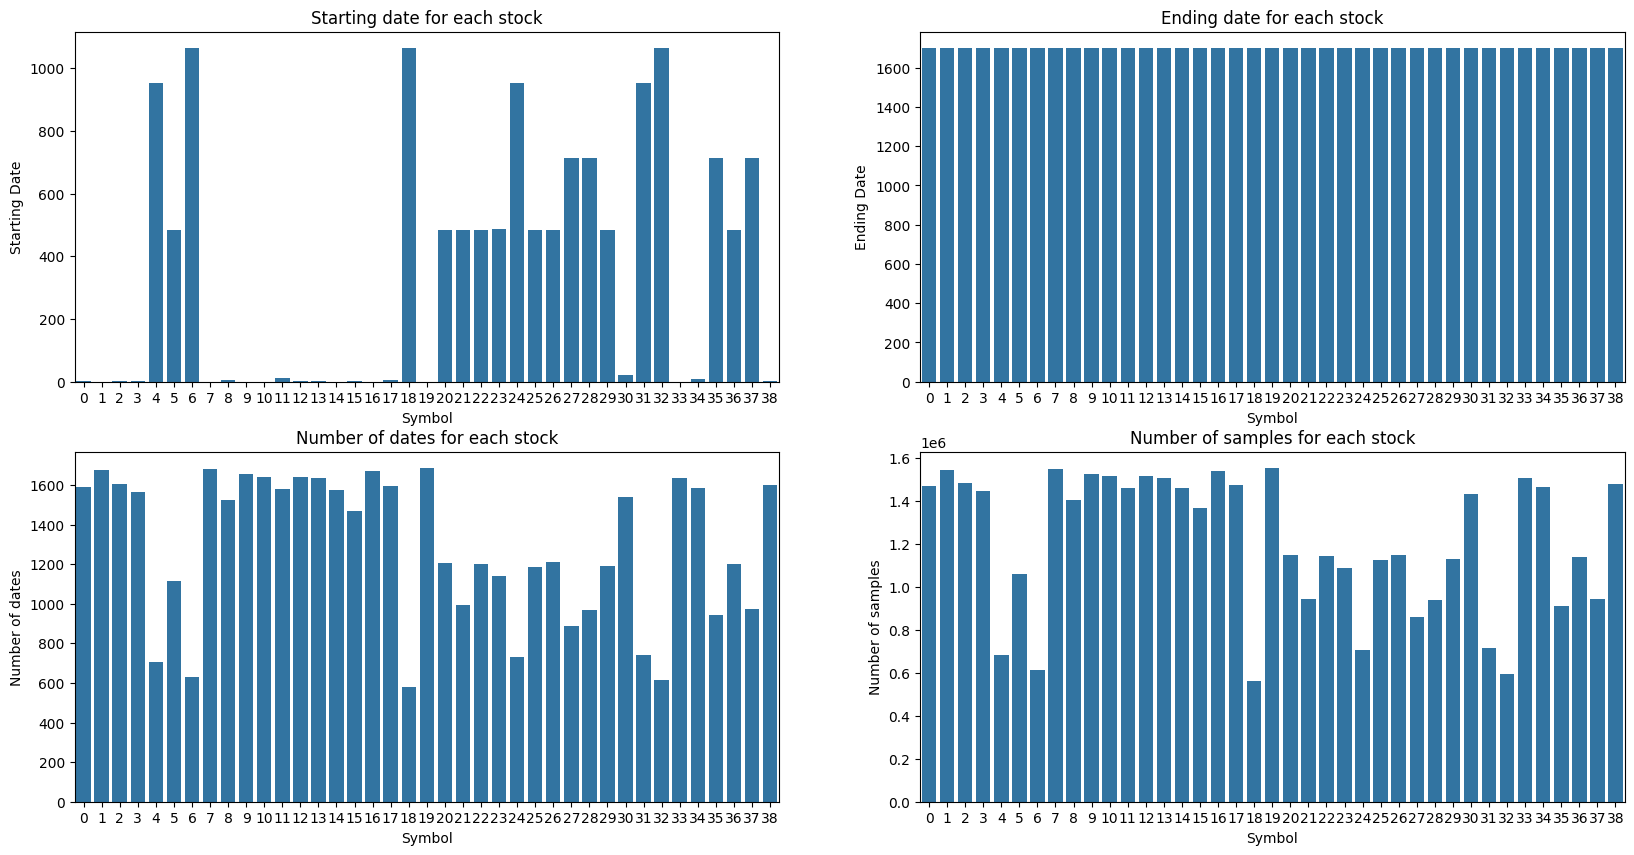

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()

sns.barplot(ax=axes[0], x=symbol_stats['symbol_id'].to_numpy(), y=symbol_stats['min_date_id'].to_numpy())
axes[0].set_xlabel('Symbol')
axes[0].set_ylabel('Starting Date')
axes[0].set_title('Starting date for each stock')

sns.barplot(ax=axes[1], x=symbol_stats['symbol_id'].to_numpy(), y=symbol_stats['max_date_id'].to_numpy())
axes[1].set_xlabel('Symbol')
axes[1].set_ylabel('Ending Date')
axes[1].set_title('Ending date for each stock')

sns.barplot(ax=axes[2], x=symbol_stats['symbol_id'].to_numpy(), y=symbol_stats['num_dates'].to_numpy())
axes[2].set_xlabel('Symbol')
axes[2].set_ylabel('Number of dates')
axes[2].set_title('Number of dates for each stock')

sns.barplot(ax=axes[3], x=symbol_stats['symbol_id'].to_numpy(), y=symbol_stats['num_samples'].to_numpy())
axes[3].set_xlabel('Symbol')
axes[3].set_ylabel('Number of samples')
axes[3].set_title('Number of samples for each stock')

# Basic Correlations

In [10]:
correlations = train_ds.drop(['date_id', 'time_id', 'symbol_id', 'weight']).drop_nulls().corr()
correlations.head()

shape: (5, 88)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ feature_0 ┆ feature_0 ┆ feature_0 ┆ feature_0 ┆ … ┆ responder ┆ responder ┆ responder ┆ responde │
│ 0         ┆ 1         ┆ 2         ┆ 3         ┆   ┆ _5        ┆ _6        ┆ _7        ┆ r_8      │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 1.0       ┆ 0.025261  ┆ 0.767813  ┆ 0.772774  ┆ … ┆ 0.004388  ┆ 0.011501  ┆ 0.024859  ┆ 0.004768 │
│ 0.025261  ┆ 1.0       ┆ -0.124191 ┆ -0.103427 ┆ … ┆ -0.013113 ┆ -0.014284 ┆ -0.005103 ┆ -0.01068 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 9        │
│ 0.767813  ┆ -0.124191 ┆ 1.0       ┆ 0.782092  ┆ … ┆ 0.008531  ┆ 0.016117  ┆ 0.026825  ┆ 0.008254 │
│ 0.772774  ┆ -0.103427 ┆ 0.782092  ┆ 1.0       ┆ … ┆ 0.006302  ┆ 0.013391  ┆ 0.025808  ┆ 0.005945 │
│ 0.041156  ┆ 0.300673  ┆ -0.064659 ┆ -0.0016   ┆ … ┆ -0.027555 ┆ -0.035338 ┆ -0.021022 ┆ -0.02790 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 2        │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

<Axes: >

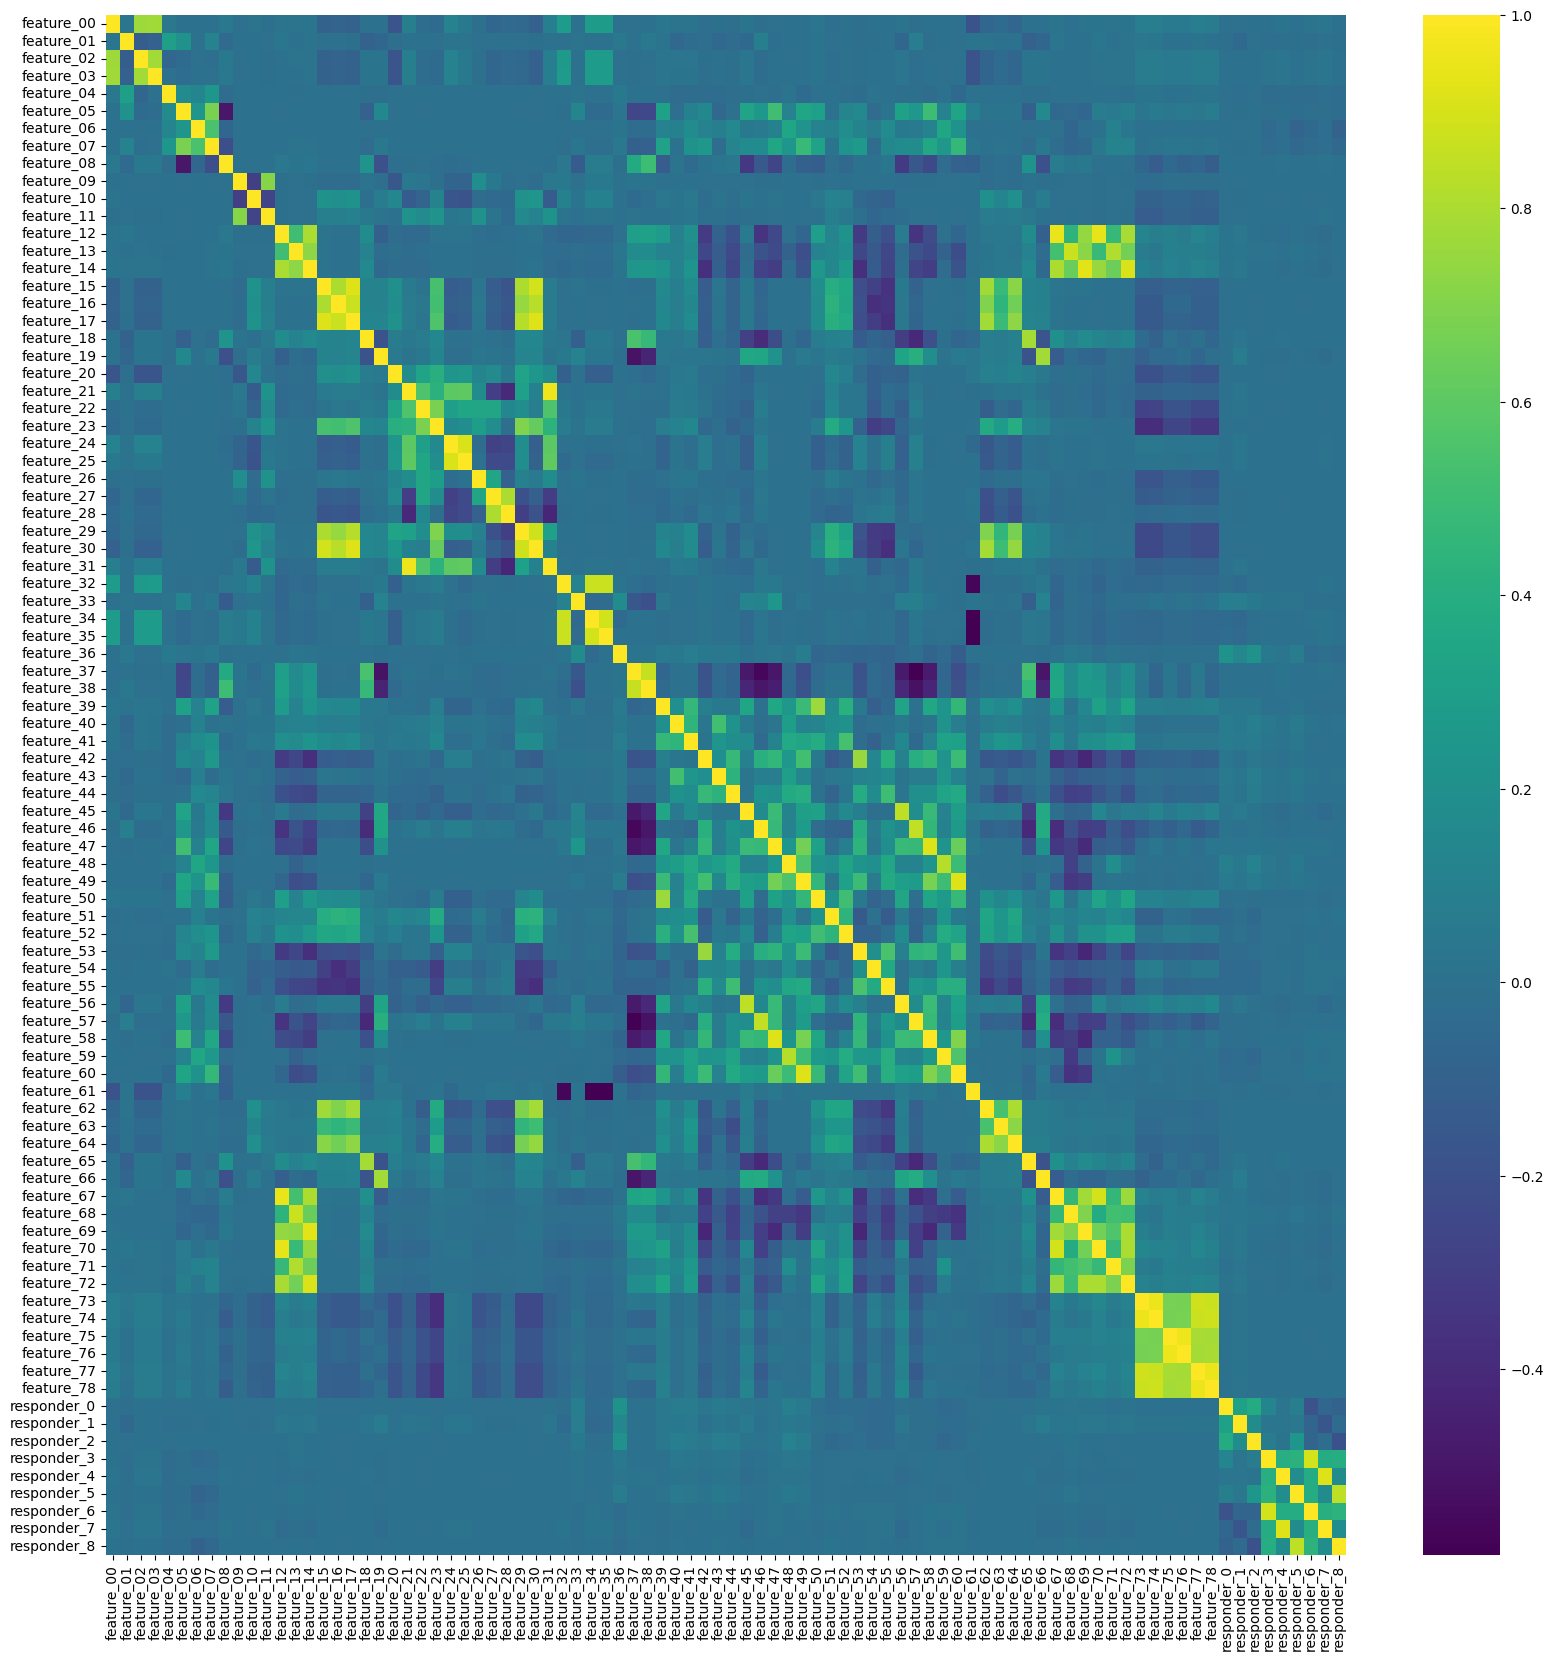

In [11]:
correlations = correlations.to_pandas()
correlations.index = correlations.columns.values

plt.figure(figsize=(20, 20))
sns.heatmap(correlations, cmap='viridis')

<Axes: >

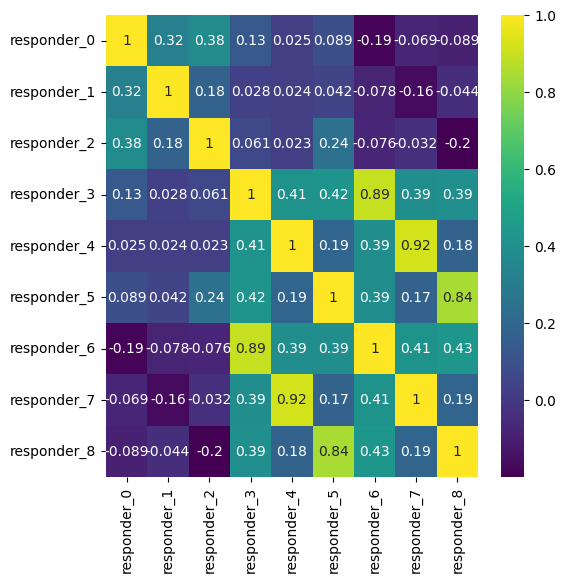

In [12]:
plt.figure(figsize=(6, 6))
sns.heatmap(correlations.iloc[-9:, -9:], cmap='viridis', annot=True)

Responder 6 and 3 are higly correlated

In [13]:
responders_tags = pl.read_csv(DATA_DIR / 'responders.csv')
responders_tags

shape: (9, 6)
┌─────────────┬───────┬───────┬───────┬───────┬───────┐
│ responder   ┆ tag_0 ┆ tag_1 ┆ tag_2 ┆ tag_3 ┆ tag_4 │
│ ---         ┆ ---   ┆ ---   ┆ ---   ┆ ---   ┆ ---   │
│ str         ┆ bool  ┆ bool  ┆ bool  ┆ bool  ┆ bool  │
╞═════════════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ responder_0 ┆ true  ┆ false ┆ true  ┆ false ┆ false │
│ responder_1 ┆ true  ┆ false ┆ false ┆ true  ┆ false │
│ responder_2 ┆ true  ┆ true  ┆ false ┆ false ┆ false │
│ responder_3 ┆ false ┆ false ┆ true  ┆ false ┆ true  │
│ responder_4 ┆ false ┆ false ┆ false ┆ true  ┆ true  │
│ responder_5 ┆ false ┆ true  ┆ false ┆ false ┆ true  │
│ responder_6 ┆ false ┆ false ┆ true  ┆ false ┆ false │
│ responder_7 ┆ false ┆ false ┆ false ┆ true  ┆ false │
│ responder_8 ┆ false ┆ true  ┆ false ┆ false ┆ false │
└─────────────┴───────┴───────┴───────┴───────┴───────┘

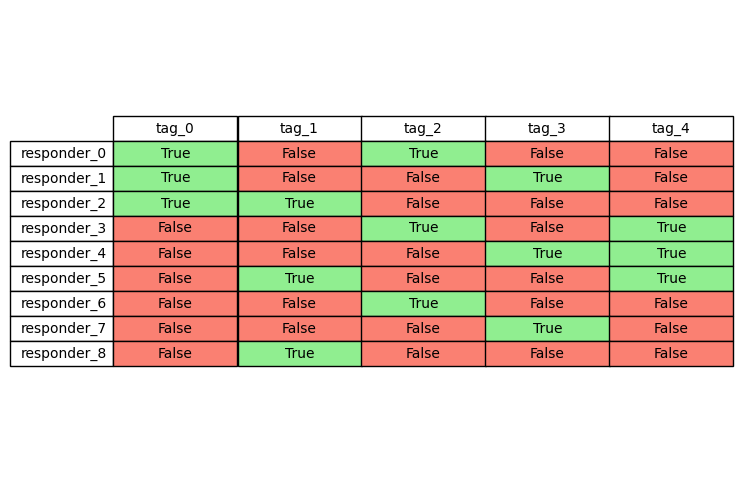

In [14]:
data = responders_tags.to_numpy()[:, 1:]

row_names = responders_tags['responder'].to_list()
col_names = responders_tags.columns[1:]

colors = np.where(data, "lightgreen", "salmon")

fig, ax = plt.subplots(figsize=(8, 6))
ax.axis("tight")
ax.axis("off")
cell_text = np.where(data, "True", "False")
table = ax.table(
    cellText=cell_text,
    cellColours=colors,
    rowLabels=row_names,
    colLabels=col_names,
    loc="center",
    cellLoc="center"
)
table.scale(1, 1.5)
plt.show()


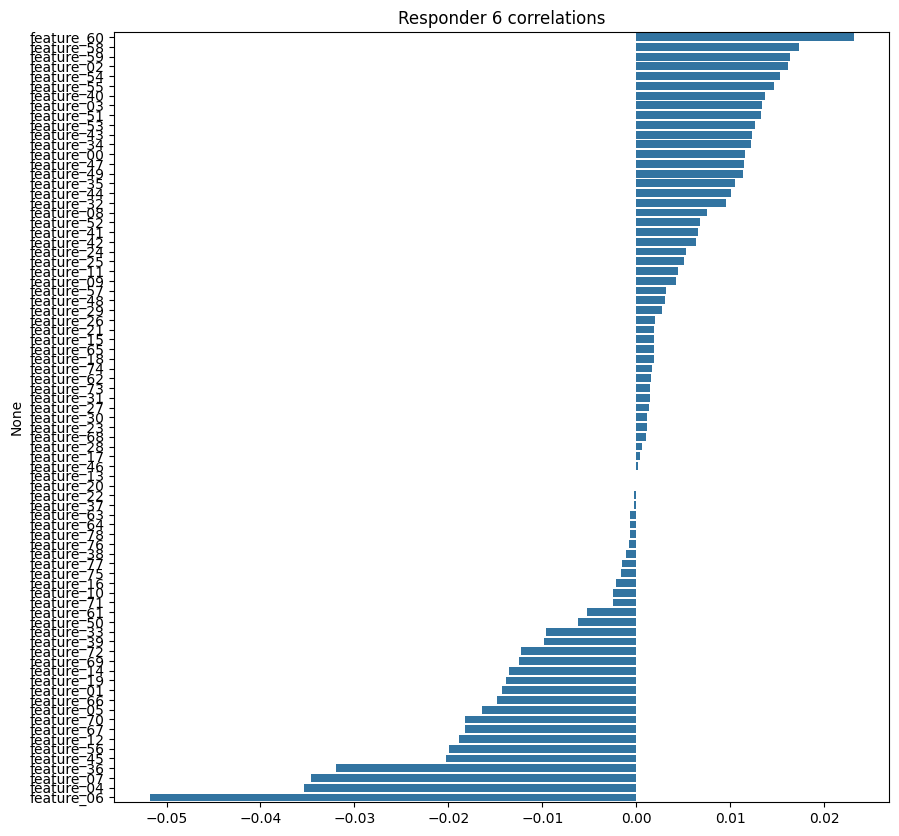

In [15]:
responder_6_correlations = correlations['responder_6'][:-9].sort_values(ascending=False)

plt.figure(figsize=(10, 10))
sns.barplot(y=responder_6_correlations.index, x=responder_6_correlations.values)
plt.title('Responder 6 correlations');

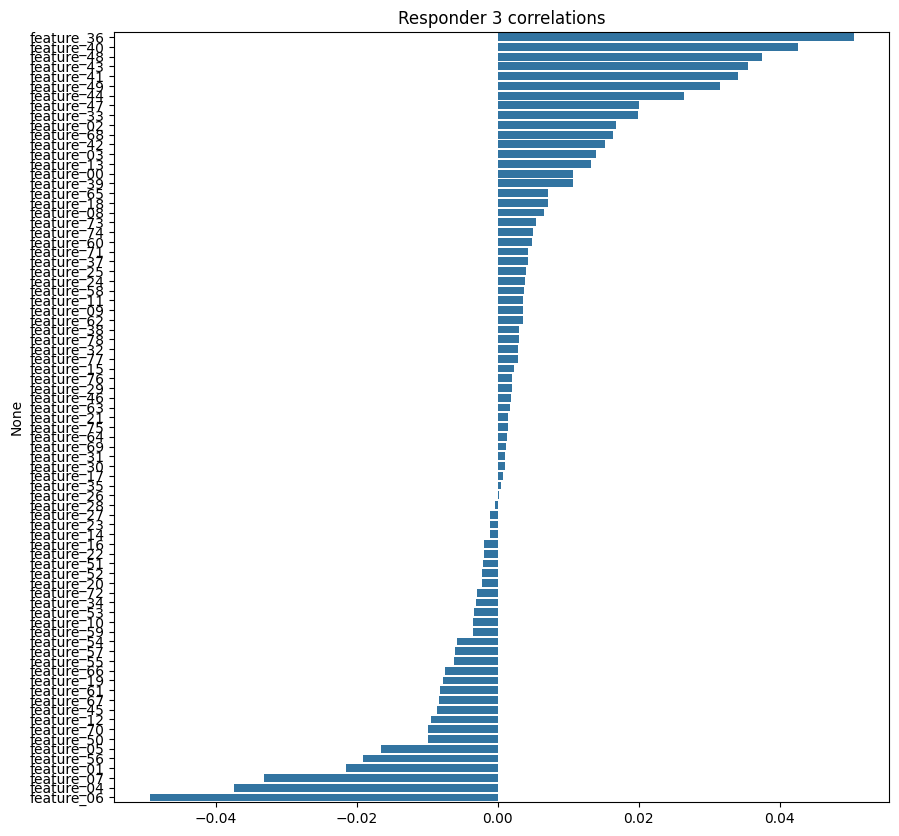

In [16]:
responder_3_correlations = correlations['responder_3'][:-9].sort_values(ascending=False)

plt.figure(figsize=(10, 10))
sns.barplot(y=responder_3_correlations.index, x=responder_3_correlations.values)
plt.title('Responder 3 correlations');

# Responders

In [17]:
RESPONDERS = [f'responder_{i}' for i in range(9)]

In [18]:
stock_1_responders = responders.filter(pl.col('symbol_id') == 1)
stock_1_responders.head(3)

shape: (3, 12)
┌─────────┬─────────┬───────────┬────────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ date_id ┆ time_id ┆ symbol_id ┆ responder_ ┆ … ┆ responder_ ┆ responder_ ┆ responder ┆ responder │
│ ---     ┆ ---     ┆ ---       ┆ 0          ┆   ┆ 5          ┆ 6          ┆ _7        ┆ _8        │
│ i16     ┆ i16     ┆ i8        ┆ ---        ┆   ┆ ---        ┆ ---        ┆ ---       ┆ ---       │
│         ┆         ┆           ┆ f32        ┆   ┆ f32        ┆ f32        ┆ f32       ┆ f32       │
╞═════════╪═════════╪═══════════╪════════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 850     ┆ 0       ┆ 1         ┆ -0.086088  ┆ … ┆ -1.016843  ┆ 0.789595   ┆ 1.251492  ┆ -1.701416 │
│ 850     ┆ 1       ┆ 1         ┆ 0.076523   ┆ … ┆ -1.902759  ┆ 0.858545   ┆ 1.521603  ┆ -1.731213 │
│ 850     ┆ 2       ┆ 1         ┆ -0.347433  ┆ … ┆ -1.553305  ┆ 0.786362   ┆ 1.221645  ┆ -1.302147 │
└─────────┴─────────┴───────────┴────────────┴───┴────────────┴────────────┴───────────┴───────────┘

<Axes: ylabel='Count'>

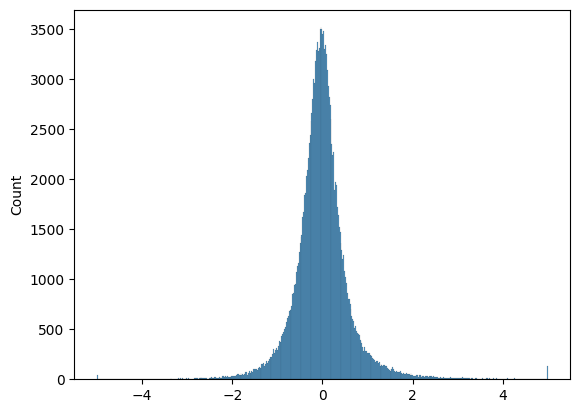

In [19]:
sns.histplot(stock_1_responders['responder_6'].to_numpy())

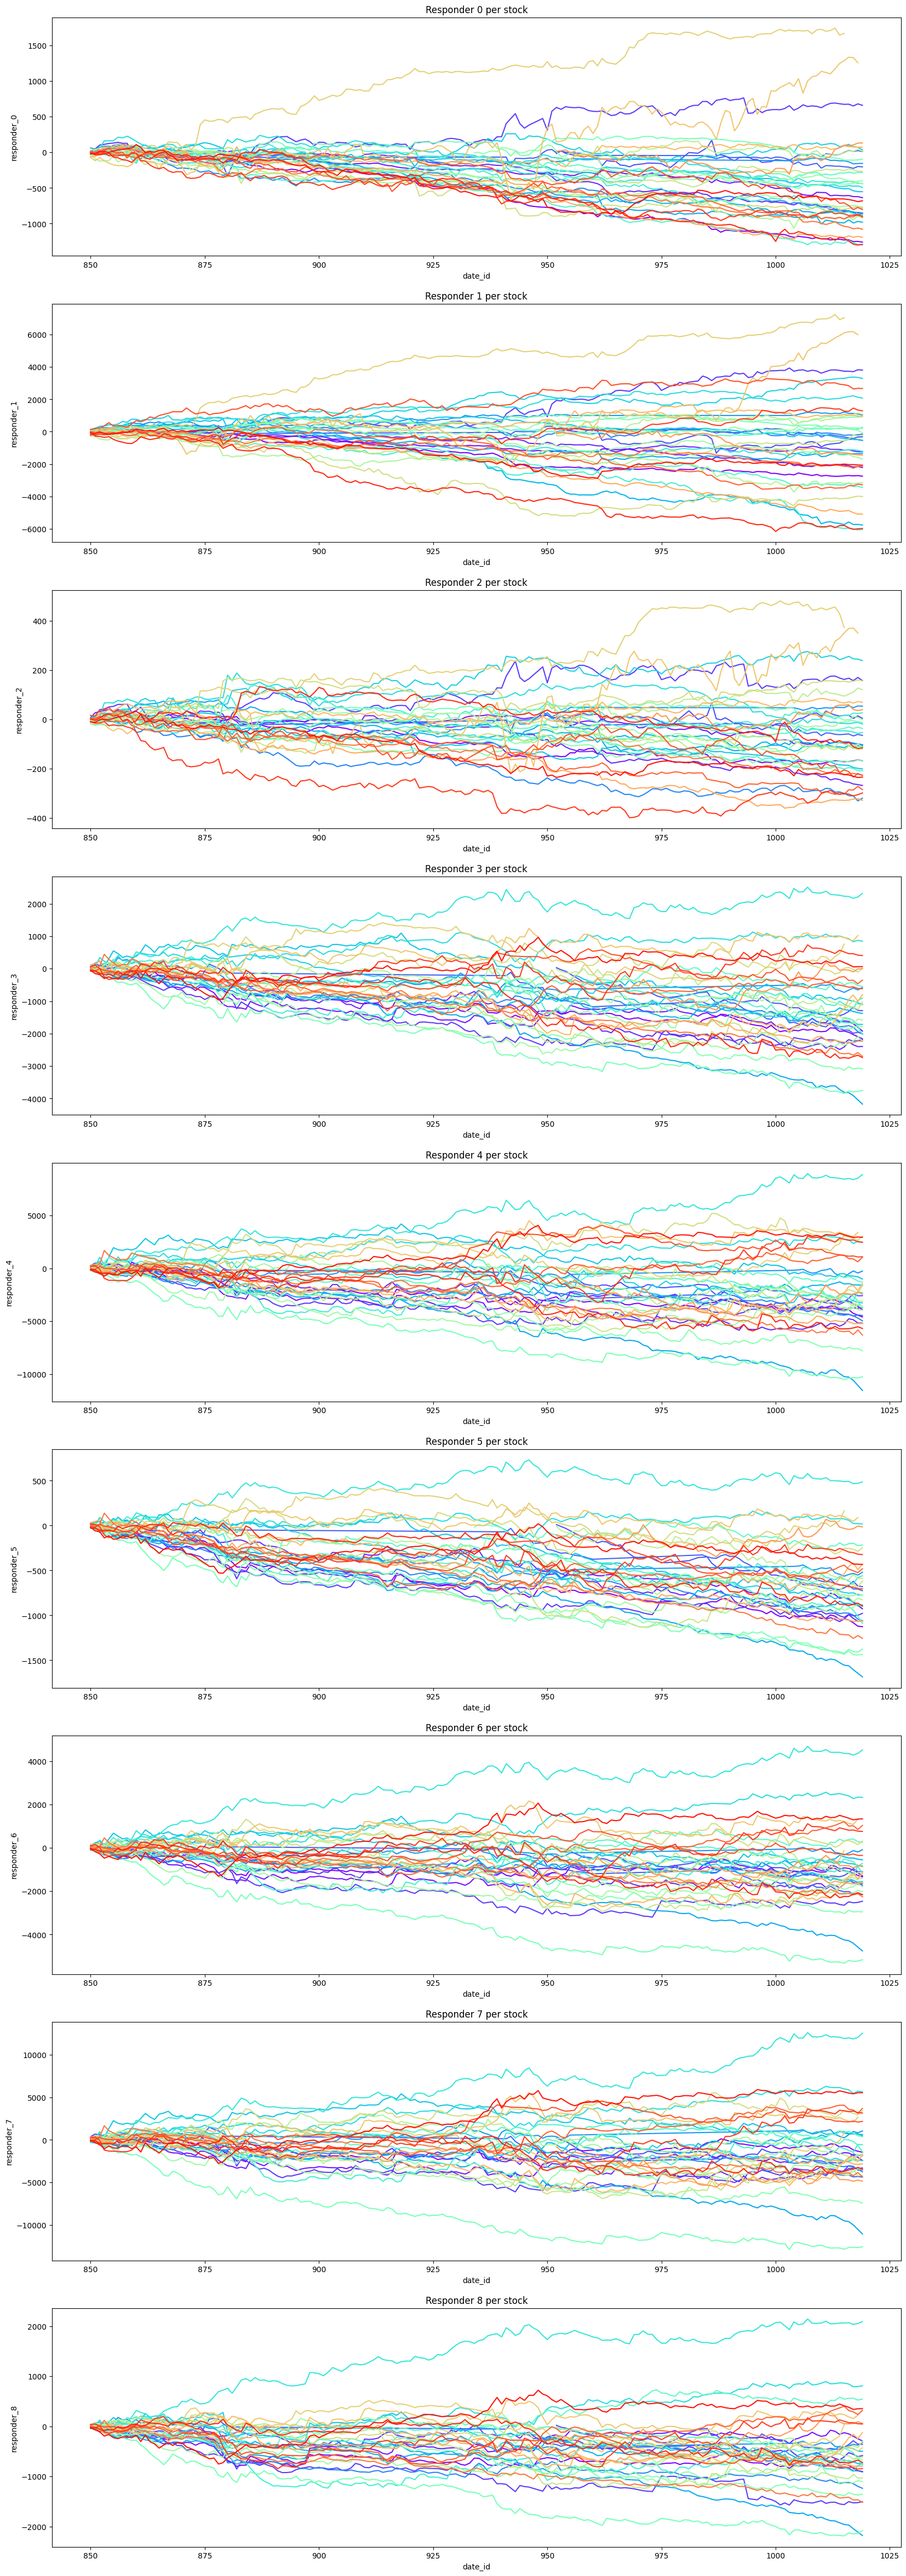

In [20]:
from matplotlib import cm

daily_responders = responders.group_by(['date_id', 'symbol_id']).agg(pl.col(RESPONDERS).sum())

colors = [cm.rainbow(i / 39)[:3] for i in range(39)]
fig, axes = plt.subplots(9, 1, figsize=(20, 60))

for i in range(9):
    for j in range(39):
        stock_data = daily_responders.filter(pl.col('symbol_id') == j).sort('date_id')
        axes[i].plot(stock_data['date_id'].to_numpy(), stock_data[f'responder_{i}'].to_numpy().cumsum(), color=colors[j])
    axes[i].set_xlabel('date_id')
    axes[i].set_ylabel(f'responder_{i}')
    axes[i].set_title(f'Responder {i} per stock')
    
plt.show()

In [21]:
time_responders = responders.group_by(['date_id', 'time_id']).agg(pl.col(RESPONDERS).sum())
time_responders.head()

shape: (5, 11)
┌─────────┬─────────┬────────────┬────────────┬───┬────────────┬───────────┬───────────┬───────────┐
│ date_id ┆ time_id ┆ responder_ ┆ responder_ ┆ … ┆ responder_ ┆ responder ┆ responder ┆ responder │
│ ---     ┆ ---     ┆ 0          ┆ 1          ┆   ┆ 5          ┆ _6        ┆ _7        ┆ _8        │
│ i16     ┆ i16     ┆ ---        ┆ ---        ┆   ┆ ---        ┆ ---       ┆ ---       ┆ ---       │
│         ┆         ┆ f32        ┆ f32        ┆   ┆ f32        ┆ f32       ┆ f32       ┆ f32       │
╞═════════╪═════════╪════════════╪════════════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ 1008    ┆ 899     ┆ 2.16705    ┆ 13.262835  ┆ … ┆ -0.095442  ┆ -24.7493  ┆ -23.78750 ┆ -1.189018 │
│         ┆         ┆            ┆            ┆   ┆            ┆           ┆ 6         ┆           │
│ 881     ┆ 925     ┆ 4.093214   ┆ 23.94171   ┆ … ┆ 9.100081   ┆ 7.348633  ┆ 2.424644  ┆ 16.251112 │
│ 929     ┆ 195     ┆ -1.497762  ┆ -3.412237  ┆ … ┆ 1.689774   ┆ 2.068233  ┆ 9.08637   ┆ 5.555643  │
│ 915     ┆ 542     ┆ 1.390691   ┆ 1.564501   ┆ … ┆ -1.068484  ┆ -8.934887 ┆ -6.989318 ┆ -4.005333 │
│ 978     ┆ 166     ┆ -1.969347  ┆ -1.858771  ┆ … ┆ 0.335541   ┆ 2.274777  ┆ -0.460695 ┆ -3.857424 │
└─────────┴─────────┴────────────┴────────────┴───┴────────────┴───────────┴───────────┴───────────┘

Responder 6 is not zero-sum at the same time (not normalized w.r.t. the market)

<Axes: ylabel='Count'>

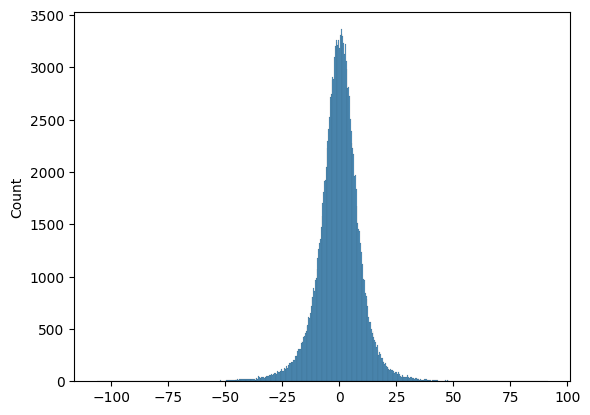

In [22]:
sns.histplot(time_responders['responder_6'].to_numpy())

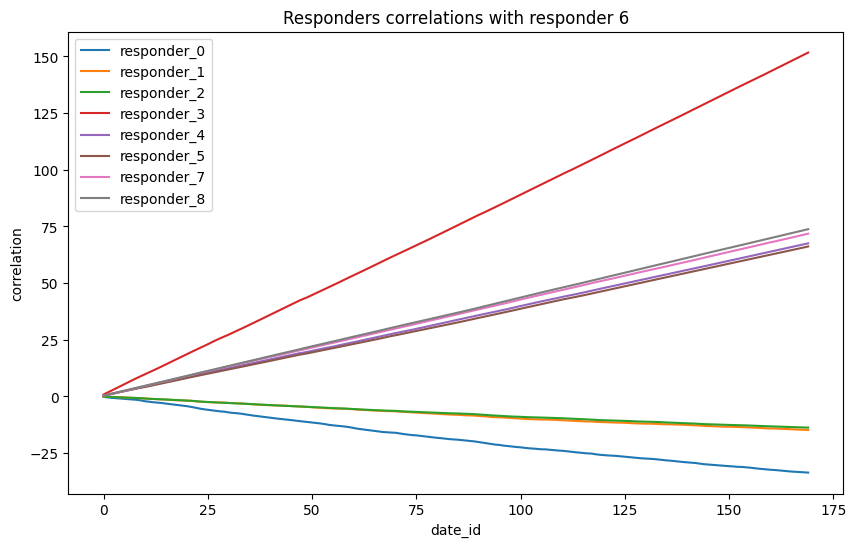

In [23]:
daily_cumulative_correlations = responders.group_by('date_id').agg(
    pl.corr(f'responder_{i}', 'responder_6') for i in range(9) if i != 6
).sort('date_id').with_columns(pl.col(f'responder_{i}').cum_sum() for i in range(9) if i != 6)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i in range(9):
    if i != 6:
        ax.plot(daily_cumulative_correlations[f'responder_{i}'], label=f'responder_{i}')
ax.set_xlabel('date_id')
ax.set_ylabel('correlation')
ax.set_title('Responders correlations with responder 6')
ax.legend()
plt.show()

# Lagged Responders

In [24]:
responders = train_ds.select(['date_id', 'time_id', 'symbol_id'] + [f'responder_{i}' for i in range(9)])

agg_responders = responders.group_by(['date_id', 'symbol_id']).agg(
    [pl.col(f'responder_{i}').sum().alias(f'total_responder_{i}') for i in range(9)] + \
    [pl.col(f'responder_{i}').mean().alias(f'mean_responder_{i}') for i in range(9)]
).with_columns(pl.col('date_id').add(1))
one_day_lagged_responders = responders.with_columns(pl.col('date_id').add(1))

responders = responders.join(agg_responders, on=['date_id', 'symbol_id'], how='left') \
    .join(one_day_lagged_responders, on=['date_id', 'time_id', 'symbol_id']) \
    .rename({f'responder_{i}_right': f'responder_{i}_lag_daily' for i in range(9)}) \
    .sort(['date_id', 'time_id', 'symbol_id'])
responders.tail(5)

shape: (5, 39)
┌─────────┬─────────┬───────────┬────────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ date_id ┆ time_id ┆ symbol_id ┆ responder_ ┆ … ┆ responder_ ┆ responder_ ┆ responder ┆ responder │
│ ---     ┆ ---     ┆ ---       ┆ 0          ┆   ┆ 5_lag_dail ┆ 6_lag_dail ┆ _7_lag_da ┆ _8_lag_da │
│ i16     ┆ i16     ┆ i8        ┆ ---        ┆   ┆ y          ┆ y          ┆ ily       ┆ ily       │
│         ┆         ┆           ┆ f32        ┆   ┆ ---        ┆ ---        ┆ ---       ┆ ---       │
│         ┆         ┆           ┆            ┆   ┆ f32        ┆ f32        ┆ f32       ┆ f32       │
╞═════════╪═════════╪═══════════╪════════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 1019    ┆ 967     ┆ 34        ┆ -1.746343  ┆ … ┆ 1.126961   ┆ -0.228563  ┆ -0.067354 ┆ -0.497763 │
│ 1019    ┆ 967     ┆ 35        ┆ -0.421249  ┆ … ┆ 0.65633    ┆ 0.106332   ┆ 0.078507  ┆ 0.197467  │
│ 1019    ┆ 967     ┆ 36        ┆ -0.684582  ┆ … ┆ 0.288754   ┆ -0.29437   ┆ -0.126703 ┆ -0.622048 │
│ 1019    ┆ 967     ┆ 37        ┆ 0.173537   ┆ … ┆ 0.874298   ┆ -0.008214  ┆ 0.02792   ┆ -0.036234 │
│ 1019    ┆ 967     ┆ 38        ┆ 0.826568   ┆ … ┆ 0.158795   ┆ -0.039505  ┆ -0.002853 ┆ -0.111305 │
└─────────┴─────────┴───────────┴────────────┴───┴────────────┴────────────┴───────────┴───────────┘

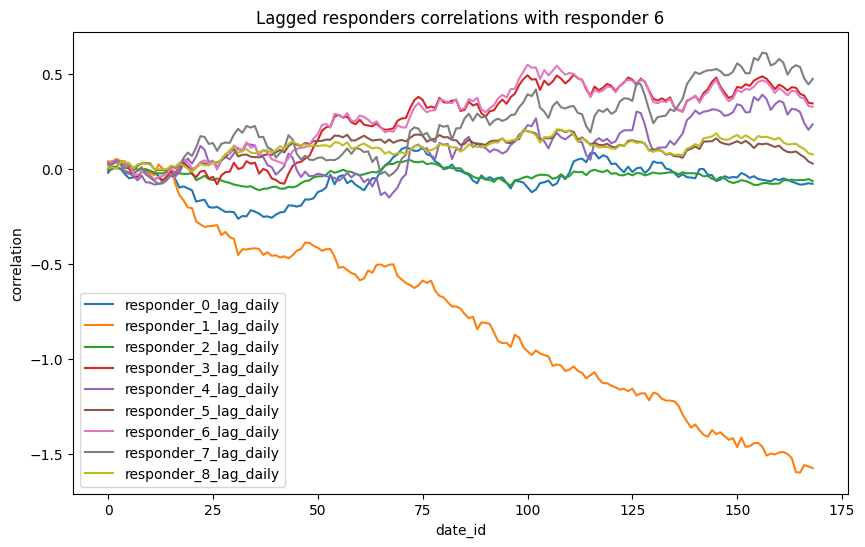

In [25]:
daily_cumulative_correlations = responders.group_by('date_id').agg(
    pl.corr(f'responder_{i}_lag_daily', 'responder_6') for i in range(9)
).sort('date_id').with_columns(pl.col(f'responder_{i}_lag_daily').cum_sum() for i in range(9))

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i in range(9):
    ax.plot(daily_cumulative_correlations[f'responder_{i}_lag_daily'], label=f'responder_{i}_lag_daily')
ax.set_xlabel('date_id')
ax.set_ylabel('correlation')
ax.set_title('Lagged responders correlations with responder 6')
ax.legend()
plt.show()

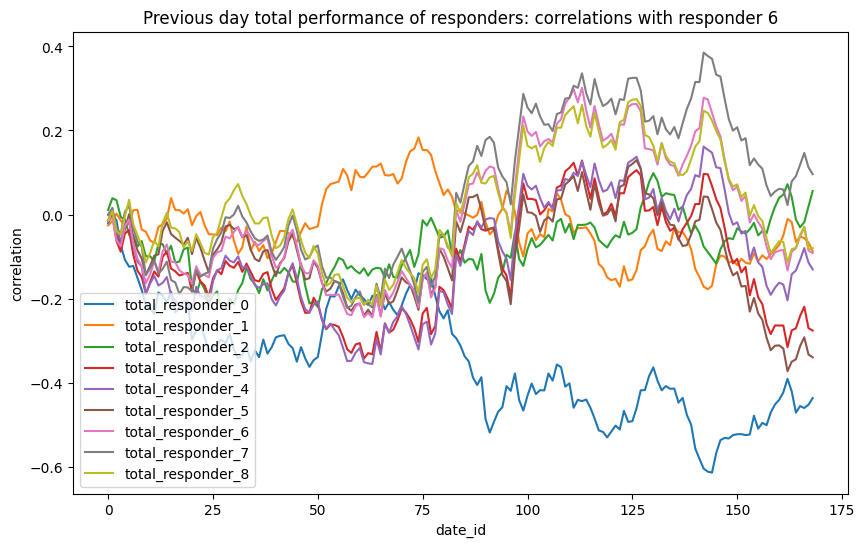

In [26]:
daily_cumulative_correlations = responders.group_by('date_id').agg(
    pl.corr(f'total_responder_{i}', 'responder_6') for i in range(9)
).sort('date_id').with_columns(pl.col(f'total_responder_{i}').cum_sum() for i in range(9))

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i in range(9):
    ax.plot(daily_cumulative_correlations[f'total_responder_{i}'], label=f'total_responder_{i}')
ax.set_xlabel('date_id')
ax.set_ylabel('correlation')
ax.set_title('Previous day total performance of responders: correlations with responder 6')
ax.legend()
plt.show()

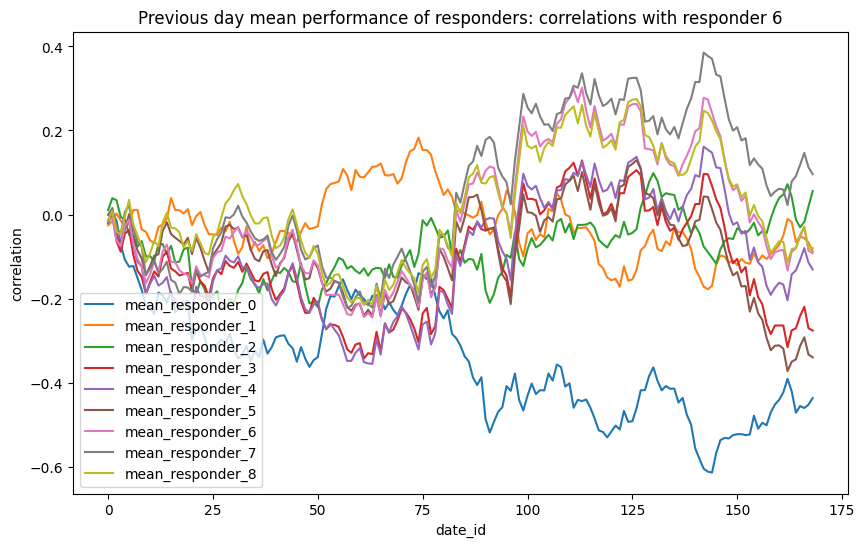

In [27]:
daily_cumulative_correlations = responders.group_by('date_id').agg(
    pl.corr(f'mean_responder_{i}', 'responder_6') for i in range(9)
).sort('date_id').with_columns(pl.col(f'mean_responder_{i}').cum_sum() for i in range(9))

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i in range(9):
    ax.plot(daily_cumulative_correlations[f'mean_responder_{i}'], label=f'mean_responder_{i}')
ax.set_xlabel('date_id')
ax.set_ylabel('correlation')
ax.set_title('Previous day mean performance of responders: correlations with responder 6')
ax.legend()
plt.show()

In [28]:
weekly_performances = responders.group_by(['date_id', 'symbol_id']).agg(
    [pl.col(f'responder_{i}_lag_daily').sum().alias(f'daily_performance_responder_{i}') for i in range(9)] + \
    [pl.col('time_id').count().alias('num_times')]
).with_columns(
    [pl.col(f'daily_performance_responder_{i}').rolling_sum(7, min_periods=1).alias(f'weekly_performance_responder_{i}') for i in range(9)] + \
    [pl.col('num_times').rolling_sum(7, min_periods=1).alias('num_times_week')]
).with_columns(
    pl.col(f'weekly_performance_responder_{i}').truediv('num_times_week').alias(f'weekly_mean_performance_responder_{i}') for i in range(9)
)
weekly_performances.tail()

shape: (5, 31)
┌─────────┬───────────┬────────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ date_id ┆ symbol_id ┆ daily_perf ┆ daily_per ┆ … ┆ weekly_me ┆ weekly_me ┆ weekly_me ┆ weekly_me │
│ ---     ┆ ---       ┆ ormance_re ┆ formance_ ┆   ┆ an_perfor ┆ an_perfor ┆ an_perfor ┆ an_perfor │
│ i16     ┆ i8        ┆ sponder_0  ┆ responder ┆   ┆ mance_res ┆ mance_res ┆ mance_res ┆ mance_res │
│         ┆           ┆ ---        ┆ _1        ┆   ┆ pon…      ┆ pon…      ┆ pon…      ┆ pon…      │
│         ┆           ┆ f32        ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│         ┆           ┆            ┆ f32       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞═════════╪═══════════╪════════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 895     ┆ 9         ┆ -19.2791   ┆ -24.00604 ┆ … ┆ 0.007204  ┆ 0.014652  ┆ 0.080685  ┆ 0.014488  │
│         ┆           ┆            ┆ 8         ┆   ┆           ┆           ┆           ┆           │
│ 879     ┆ 36        ┆ -30.835739 ┆ -54.90004 ┆ … ┆ 0.002071  ┆ 0.005202  ┆ 0.039731  ┆ 0.00662   │
│         ┆           ┆            ┆ 3         ┆   ┆           ┆           ┆           ┆           │
│ 960     ┆ 17        ┆ -12.642724 ┆ -15.23228 ┆ … ┆ 0.006533  ┆ 0.018322  ┆ 0.076841  ┆ 0.0143    │
│         ┆           ┆            ┆ 1         ┆   ┆           ┆           ┆           ┆           │
│ 947     ┆ 23        ┆ 6.92916    ┆ -27.63362 ┆ … ┆ 0.008232  ┆ 0.012903  ┆ 0.064577  ┆ 0.0146    │
│         ┆           ┆            ┆ 5         ┆   ┆           ┆           ┆           ┆           │
│ 940     ┆ 34        ┆ -48.893353 ┆ -229.0945 ┆ … ┆ 0.013472  ┆ 0.041169  ┆ 0.147173  ┆ 0.024879  │
│         ┆           ┆            ┆ 43        ┆   ┆           ┆           ┆           ┆           │
└─────────┴───────────┴────────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

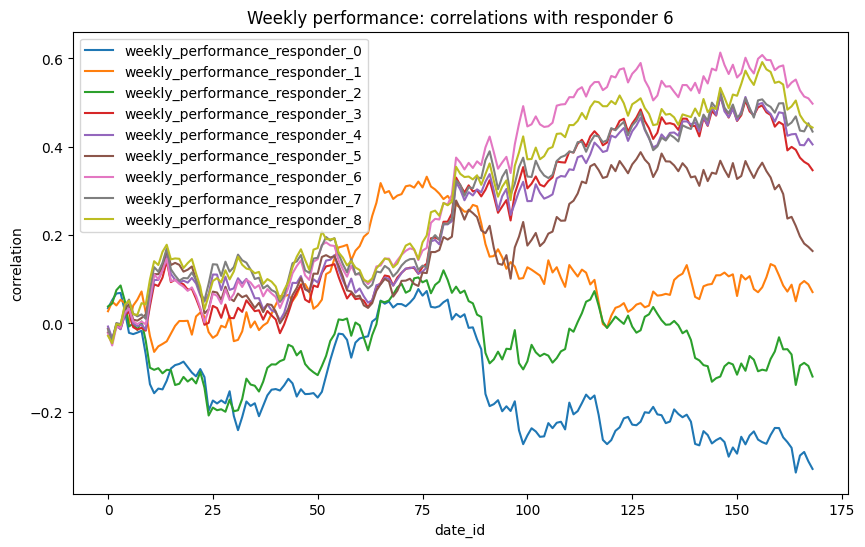

In [29]:
daily_cumulative_correlations = responders \
    .join(weekly_performances, on=['symbol_id', 'date_id']).group_by('date_id').agg(
        [pl.corr(f'weekly_performance_responder_{i}', 'responder_6') for i in range(9)] + \
        [pl.corr(f'weekly_mean_performance_responder_{i}', 'responder_6') for i in range(9)]
    ).sort('date_id')\
    .with_columns(
        *[pl.col(f'weekly_performance_responder_{i}').cum_sum() for i in range(9)],
        *[pl.col(f'weekly_mean_performance_responder_{i}').cum_sum() for i in range(9)]
    )

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i in range(9):
    ax.plot(daily_cumulative_correlations[f'weekly_performance_responder_{i}'], label=f'weekly_performance_responder_{i}')
ax.set_xlabel('date_id')
ax.set_ylabel('correlation')
ax.set_title('Weekly performance: correlations with responder 6')
ax.legend()
plt.show()

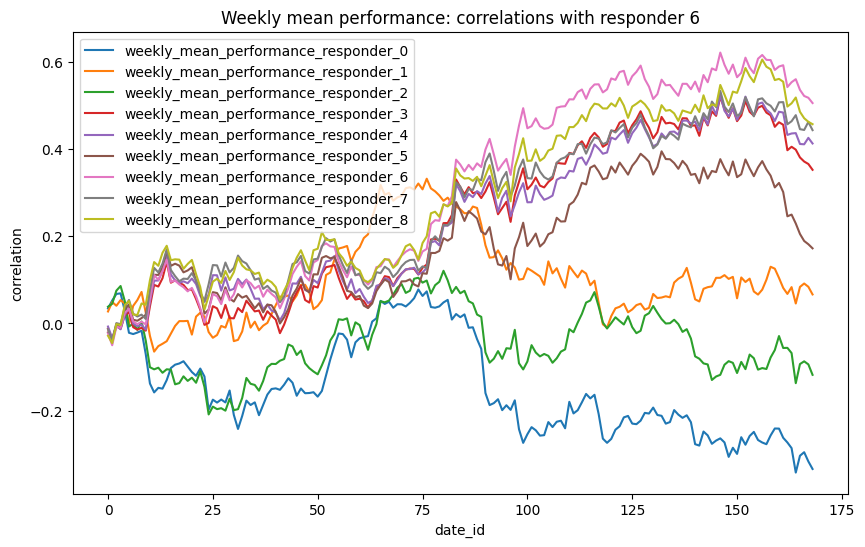

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i in range(9):
    ax.plot(daily_cumulative_correlations[f'weekly_mean_performance_responder_{i}'], label=f'weekly_mean_performance_responder_{i}')
ax.set_xlabel('date_id')
ax.set_ylabel('correlation')
ax.set_title('Weekly mean performance: correlations with responder 6')
ax.legend()
plt.show()

In [31]:
responders = responders.sort(['date_id', 'time_id', 'symbol_id'])
responders.head(3)

shape: (3, 39)
┌─────────┬─────────┬───────────┬────────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ date_id ┆ time_id ┆ symbol_id ┆ responder_ ┆ … ┆ responder_ ┆ responder_ ┆ responder ┆ responder │
│ ---     ┆ ---     ┆ ---       ┆ 0          ┆   ┆ 5_lag_dail ┆ 6_lag_dail ┆ _7_lag_da ┆ _8_lag_da │
│ i16     ┆ i16     ┆ i8        ┆ ---        ┆   ┆ y          ┆ y          ┆ ily       ┆ ily       │
│         ┆         ┆           ┆ f32        ┆   ┆ ---        ┆ ---        ┆ ---       ┆ ---       │
│         ┆         ┆           ┆            ┆   ┆ f32        ┆ f32        ┆ f32       ┆ f32       │
╞═════════╪═════════╪═══════════╪════════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 851     ┆ 0       ┆ 0         ┆ -0.184502  ┆ … ┆ 0.141694   ┆ 1.461546   ┆ 0.779843  ┆ 0.404129  │
│ 851     ┆ 0       ┆ 1         ┆ -0.267683  ┆ … ┆ -1.016843  ┆ 0.789595   ┆ 1.251492  ┆ -1.701416 │
│ 851     ┆ 0       ┆ 2         ┆ 1.442721   ┆ … ┆ -3.009765  ┆ -2.848316  ┆ -0.974728 ┆ -5.0      │
└─────────┴─────────┴───────────┴────────────┴───┴────────────┴────────────┴───────────┴───────────┘

In [32]:
features = [f'responder_{i}_lag_daily' for i in range(9)] + [f'total_responder_{i}' for i in range(9)] + [f'mean_responder_{i}' for i in range(9)]
target = 'responder_6'
daily_corr = responders.group_by(['date_id']).agg(
    pl.corr(f, target).name.keep() for f in features
).with_columns(
    #Flip sign for negative mean correlation since we only care about magnitude
    pl.all().exclude('date_id').mul(pl.all().exclude('date_id').mean().sign()).name.keep()
).sort('date_id')
daily_corr

shape: (169, 28)
┌─────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ date_id ┆ responder_ ┆ responder ┆ responder ┆ … ┆ mean_resp ┆ mean_resp ┆ mean_resp ┆ mean_resp │
│ ---     ┆ 0_lag_dail ┆ _1_lag_da ┆ _2_lag_da ┆   ┆ onder_5   ┆ onder_6   ┆ onder_7   ┆ onder_8   │
│ i16     ┆ y          ┆ ily       ┆ ily       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│         ┆ ---        ┆ ---       ┆ ---       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
│         ┆ f64        ┆ f64       ┆ f64       ┆   ┆           ┆           ┆           ┆           │
╞═════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 851     ┆ 0.019198   ┆ -0.040032 ┆ 0.008751  ┆ … ┆ 0.015777  ┆ 0.014761  ┆ 0.000352  ┆ 0.014711  │
│ 852     ┆ -0.029092  ┆ 0.00008   ┆ -0.008417 ┆ … ┆ -0.02871  ┆ -0.007479 ┆ 0.013106  ┆ -0.023092 │
│ 853     ┆ 0.00331    ┆ -0.013519 ┆ -0.009899 ┆ … ┆ 0.062707  ┆ 0.054075  ┆ -0.044165 ┆ 0.048378  │
│ 854     ┆ 0.005904   ┆ 0.010484  ┆ 0.008596  ┆ … ┆ 0.020274  ┆ 0.013683  ┆ -0.016213 ┆ 0.007898  │
│ 855     ┆ 0.027934   ┆ 0.002504  ┆ 0.011113  ┆ … ┆ -0.034265 ┆ -0.04706  ┆ 0.053554  ┆ -0.04323  │
│ …       ┆ …          ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …         │
│ 1015    ┆ 0.007689   ┆ 0.074649  ┆ 0.004295  ┆ … ┆ -0.005586 ┆ -0.008081 ┆ 0.012498  ┆ -0.003157 │
│ 1016    ┆ 0.007881   ┆ 0.002542  ┆ -0.002189 ┆ … ┆ -0.031569 ┆ -0.027654 ┆ 0.02713   ┆ -0.030923 │
│ 1017    ┆ -0.002164  ┆ -0.039677 ┆ 0.000391  ┆ … ┆ -0.021004 ┆ -0.022415 ┆ 0.028074  ┆ -0.019654 │
│ 1018    ┆ -0.005366  ┆ 0.007048  ┆ -0.00517  ┆ … ┆ 0.041133  ┆ 0.055895  ┆ -0.034113 ┆ 0.053668  │
│ 1019    ┆ 0.003146   ┆ 0.008765  ┆ 0.0107    ┆ … ┆ 0.006626  ┆ 0.005768  ┆ -0.016304 ┆ -0.002515 │
└─────────┴────────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

In [33]:
def metrics(corr):
    corr_mean = corr.mean()
    corr_std = corr.std(ddof=0)
    corr_sharpe = corr_mean / corr_std
    max_drawdown = -(corr.cumsum().expanding(min_periods=1).max() - corr.cumsum()).max()

    eras = daily_corr['date_id'].unique().sort().to_list()
    halfway_era = len(eras)//2
    corr_mean_first_half = corr.loc[eras[:halfway_era]].mean()
    corr_mean_second_half = corr.loc[eras[halfway_era:]].mean()

    delta = abs(corr_mean_first_half - corr_mean_second_half)

    return {
      "mean": corr_mean,
      "std": corr_std,
      "sharpe": corr_sharpe,
      "max_drawdown": max_drawdown,
      "delta": delta
    }

per_era_corr = daily_corr.to_pandas().set_index('date_id')
# compute performance metrics for each feature
feature_metrics = [
    metrics(per_era_corr[feature_name])
    for feature_name in features
]

# convert to numeric DataFrame and sort
feature_metrics = (
    pd.DataFrame(feature_metrics, index=features)
    .apply(pd.to_numeric)
    .sort_values("mean", ascending=False)
)

feature_metrics

mean       std    sharpe  max_drawdown     delta
responder_1_lag_daily  0.009327  0.025775  0.361847     -0.085022  0.001398
responder_7_lag_daily  0.002815  0.035917  0.078365     -0.264649  0.000514
total_responder_0      0.002581  0.027822  0.092780     -0.222998  0.001826
mean_responder_0       0.002581  0.027822  0.092780     -0.222998  0.001826
responder_3_lag_daily  0.002049  0.027661  0.074068     -0.192176  0.004553
mean_responder_5       0.002009  0.035077  0.057261     -0.370131  0.003599
total_responder_5      0.002009  0.035077  0.057261     -0.370131  0.003599
responder_6_lag_daily  0.001945  0.027893  0.069744     -0.250090  0.004847
mean_responder_3       0.001632  0.035371  0.046132     -0.470970  0.001327
total_responder_3      0.001632  0.035371  0.046132     -0.470970  0.001327
responder_4_lag_daily  0.001395  0.035763  0.039018     -0.283222  0.000260
mean_responder_4       0.000772  0.034677  0.022252     -0.516825  0.000728
total_responder_4      0.000772  0.034677  0.022252     -0.516825  0.000728
total_responder_7      0.000569  0.034823  0.016332     -0.362762  0.000095
mean_responder_7       0.000569  0.034823  0.016332     -0.362762  0.000095
mean_responder_6       0.000542  0.035039  0.015458     -0.546629  0.001341
total_responder_6      0.000542  0.035039  0.015458     -0.546629  0.001341
mean_responder_1       0.000515  0.025346  0.020300     -0.286922  0.001182
total_responder_1      0.000515  0.025346  0.020300     -0.286922  0.001182
mean_responder_8       0.000472  0.034372  0.013727     -0.491605  0.001584
total_responder_8      0.000472  0.034372  0.013727     -0.491605  0.001584
responder_0_lag_daily  0.000460  0.022157  0.020768     -0.377250  0.000734
responder_8_lag_daily  0.000457  0.015662  0.029201     -0.137451  0.001815
responder_2_lag_daily  0.000375  0.010042  0.037301     -0.158509  0.000840
mean_responder_2       0.000331  0.027419  0.012086     -0.263177  0.003129
total_responder_2      0.000331  0.027419  0.012086     -0.263177  0.003129
responder_5_lag_daily  0.000170  0.015541  0.010915     -0.177082  0.003255

array([[<Axes: title={'center': 'mean'}>,
        <Axes: title={'center': 'std'}>,
        <Axes: title={'center': 'sharpe'}>],
       [<Axes: title={'center': 'max_drawdown'}>,
        <Axes: title={'center': 'delta'}>, <Axes: >]], dtype=object)

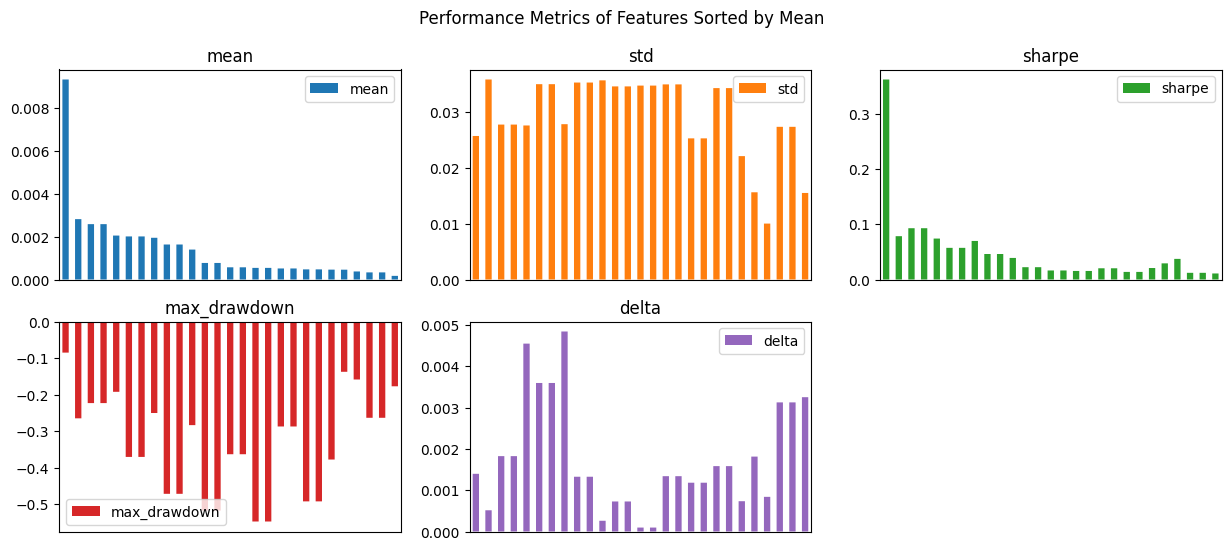

In [34]:
feature_metrics.sort_values("mean", ascending=False).plot.bar(
    title="Performance Metrics of Features Sorted by Mean",
    subplots=True,
    figsize=(15, 6),
    layout=(2, 3),
    sharex=False,
    xticks=[],
    snap=False
)

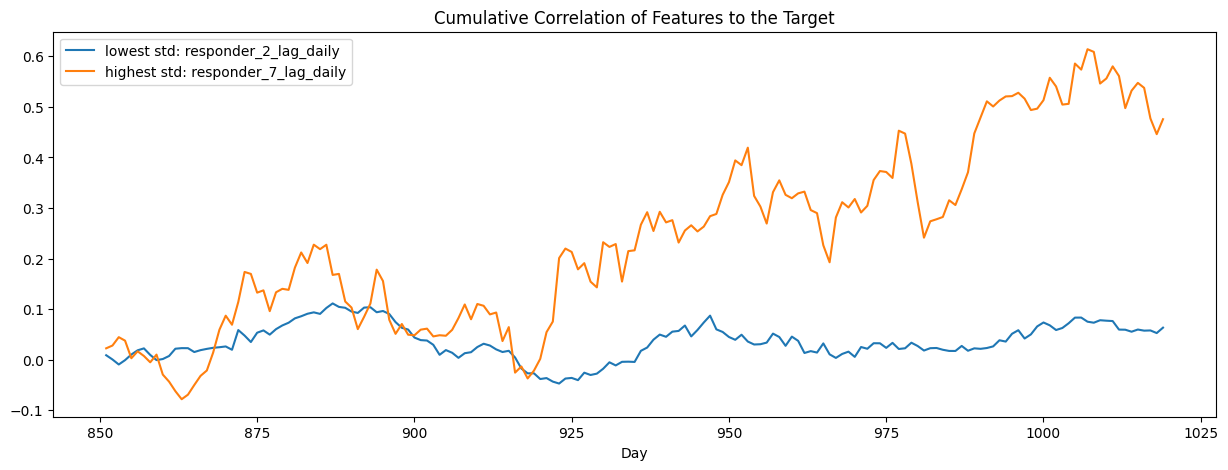

In [35]:
metric="std"
min_f, max_f = feature_metrics[metric].idxmin(), feature_metrics[metric].idxmax()
per_era_corr[[min_f, max_f]].cumsum().plot(
    figsize=(15, 5), title="Cumulative Correlation of Features to the Target", xlabel="Day"
)
plt.legend([f"lowest {metric}: {min_f}", f"highest {metric}: {max_f}"])

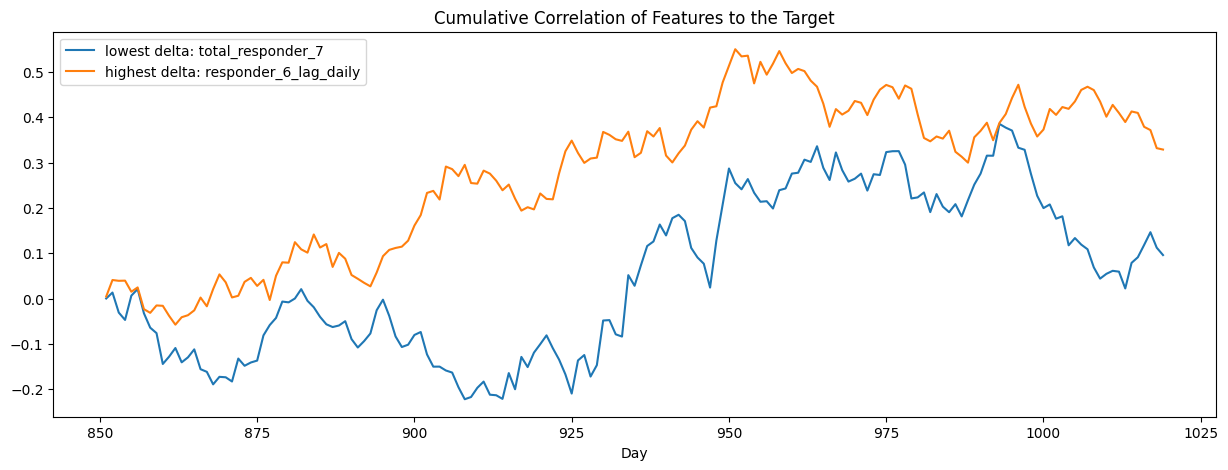

In [36]:
metric="delta"
min_f, max_f = feature_metrics[metric].idxmin(), feature_metrics[metric].idxmax()
per_era_corr[[min_f, max_f]].cumsum().plot(
    figsize=(15, 5), title="Cumulative Correlation of Features to the Target", xlabel="Day"
)
plt.legend([f"lowest {metric}: {min_f}", f"highest {metric}: {max_f}"])

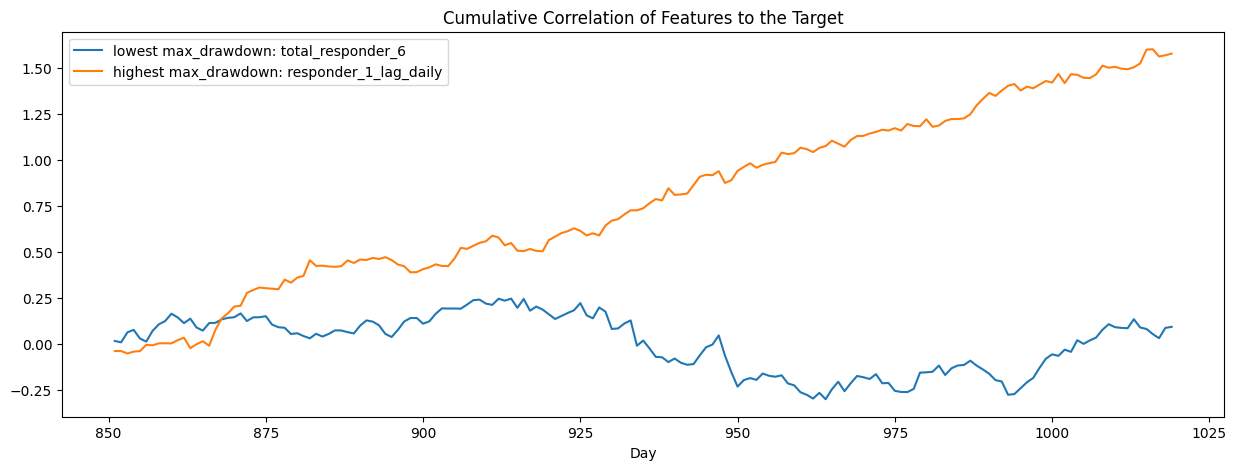

In [37]:
metric="max_drawdown"
min_f, max_f = feature_metrics[metric].idxmin(), feature_metrics[metric].idxmax()
per_era_corr[[min_f, max_f]].cumsum().plot(
    figsize=(15, 5), title="Cumulative Correlation of Features to the Target", xlabel="Day"
)
plt.legend([f"lowest {metric}: {min_f}", f"highest {metric}: {max_f}"])